# Extracting temperture projections from CMIP6 models using the Pangeo Cloud Data

We need a shapefile of the region of interest:

Found [this](https://geodata.lib.utexas.edu/catalog/stanford-xq035qm8233) with a quick google search. Specifically [this file](https://stacks.stanford.edu/file/druid:xq035qm8233/data.zip), seems like something we need.
But this should work with any kind of shapefile.

In [14]:
import geopandas as gpd
import xarray as xr
import xesmf as xe
import cf_xarray
from xmip.utils import google_cmip_col
from xmip.preprocessing import combined_preprocessing
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from xarrayutils.plotting import shaded_line_plot
%matplotlib inline

### Load the state shapefile

In [2]:
austria = gpd.read_file(
    "https://stacks.stanford.edu/file/druid:xq035qm8233/data.zip"
)
austria
# there are some duplicate regions in there. 
# Not an expert on this, but might indicate that one should use a different shapefile. 
# For the sake of demo ill drop one of them. All the steps below should be general though (maybe some different names required). 
austria = austria.iloc[[3,7]]

In [3]:
austria.plot()

<Axes: >

## Load the model data
I will load only a few models here for a demo. See [here](https://pangeo-data.github.io/pangeo-cmip6-cloud/) for more info about the cloud data. 

Some more advanced examples can be found as part of [Ryan Abernatheys book](https://earth-env-data-science.github.io/lectures/models/cmip.html)

In [4]:
# Load a few example CMIP models
col = google_cmip_col()
cat = col.search(
    variable_id='tas',
    grid_label='gn',
    table_id='Amon',
    experiment_id='historical',
    source_id=['CanESM5', 'CESM2', 'ACCESS-ESM1-5']
)
# note about datatree
ddict = cat.to_dataset_dict(preprocess=combined_preprocessing, aggregate=False, xarray_open_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
# concatenate the members
from xmip.postprocessing import concat_members
ddict_merged = concat_members(ddict)
ddict_merged.keys()

dict_keys(['CESM2.gn.historical.Amon.tas', 'CanESM5.gn.historical.Amon.tas', 'ACCESS-ESM1-5.gn.historical.Amon.tas'])

To average the coarse climate model grid properly onto the detailed polygon of the states I am using [xesmf](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Spatial_Averaging.html), but there are other (potentially faster/better methods). Check out [Ryan's blogpost](https://discourse.pangeo.io/t/conservative-region-aggregation-with-xarray-geopandas-and-sparse/2715) for more.

xesmf needs the cell bounds in a particular format. Lets write a little preprocessor to accomodate that.

In [6]:
# special processing for xesmf: the lat/lon bounds need to be in the
def convert_bounds(ds):
    ds = ds.copy()
    """Produces lon/lat bounds in the appropriate format for xESMF"""
    ## for this we actually need to use the vertices (need to correct that typo!) variable (which indicates the 4 corners of the cell)
    lon_vert = ds.lon_verticies.load()
    lat_vert = ds.lat_verticies.load()
    
    # drop the old bounds to avoid confusion
    ds = ds.drop(['lon_bounds', 'lat_bounds'])
    
    # convert using cf_xarray
    lon_bounds = cf_xarray.bounds_to_vertices(lon_vert, 'vertex')
    lat_bounds = cf_xarray.bounds_to_vertices(lat_vert, 'vertex')
    
    ds = ds.assign_coords(lon_b=lon_bounds, lat_b=lat_bounds)
    return ds

## prototype regridding on a single dataset

In [16]:
# extract a single dataset for now
ds = ddict_merged['CanESM5.gn.historical.Amon.tas']
ds

<xarray.Dataset>
Dimensions:         (member_id: 65, dcpp_init_year: 1, time: 1980, y: 64,
                     x: 128, bnds: 2, vertex: 4)
Coordinates: (12/13)
    height          float64 2.0
  * y               (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * x               (x) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lat_bounds      (y, bnds, x) float64 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon_bounds      (x, bnds, y) float64 358.6 358.6 358.6 ... 358.6 358.6 358.6
    ...              ...
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
    lat             (x, y) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    lon_verticies   (vertex, x, y) float64 358.6 358.6 358.6 ... 358.6 358.6
    lat_verticies   (vertex, x, y) float64 -90.0 -86.58 -83.76 ... 83.76 86.58
  * member_id       (member_id) object 'r10i1p1f1' 'r12i1p2f1' ... 'r24i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: bnds, vertex
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 64, 128), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                      CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:        1850:01:01:00
    activity_id:                      CMIP
    branch_method:                    Spin-up documentation
    branch_time_in_child:             0.0
    contact:                          ec.cccma.info-info.ccmac.ec@canada.ca
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190429
    intake_esm_attrs:_data_format_:   zarr

In [17]:
ds_converted = convert_bounds(ds)
ds_converted

<xarray.Dataset>
Dimensions:         (member_id: 65, dcpp_init_year: 1, time: 1980, y: 64,
                     x: 128, bnds: 2, vertex: 4, x_vertices: 129, y_vertices: 65)
Coordinates: (12/13)
    height          float64 2.0
  * y               (y) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * x               (x) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00...
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 357.2 357.2 357.2
    ...              ...
    lon_verticies   (vertex, x, y) float64 358.6 358.6 358.6 ... 358.6 358.6
    lat_verticies   (vertex, x, y) float64 -90.0 -86.58 -83.76 ... 83.76 86.58
  * member_id       (member_id) object 'r10i1p1f1' 'r12i1p2f1' ... 'r24i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lon_b           (x_vertices, y_vertices) float64 358.6 358.6 ... 358.6 358.6
    lat_b           (x_vertices, y_vertices) float64 -90.0 -86.58 ... 86.58 90.0
Dimensions without coordinates: bnds, vertex, x_vertices, y_vertices
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 64, 128), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                      CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:        1850:01:01:00
    activity_id:                      CMIP
    branch_method:                    Spin-up documentation
    branch_time_in_child:             0.0
    contact:                          ec.cccma.info-info.ccmac.ec@canada.ca
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190429
    intake_esm_attrs:_data_format_:   zarr

## Load our region of interest (Austrian states)

In [18]:
savg = xe.SpatialAverager(ds_converted, austria.geometry, geom_dim_name="state")
savg

xESMF SpatialAverager 
Weight filename:            spatialavg_128x64_2.nc 
Reuse pre-computed weights? False 
Input grid shape:           (128, 64) 
Output list length:         2 

In [19]:
out = savg(ds_converted.tas)
out = out.assign_coords(state=xr.DataArray(list(austria["NAME_1"]), dims=("state",)))
out

<xarray.DataArray (member_id: 65, dcpp_init_year: 1, time: 1980, state: 2)>
dask.array<getitem, shape=(65, 1, 1980, 2), dtype=float32, chunksize=(1, 1, 600, 2), chunktype=numpy.ndarray>
Coordinates:
    height          float64 2.0
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r10i1p1f1' 'r12i1p2f1' ... 'r24i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lon             (state) float64 13.96 11.5
    lat             (state) float64 48.14 47.2
  * state           (state) <U14 'Oberösterreich' 'Tirol'
Attributes:
    regrid_method:  conservative

## Quick visualization of the weights for each grid cell that overlaps with the region

/tmp/ipykernel_2367/126777894.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in a.axes.flat:


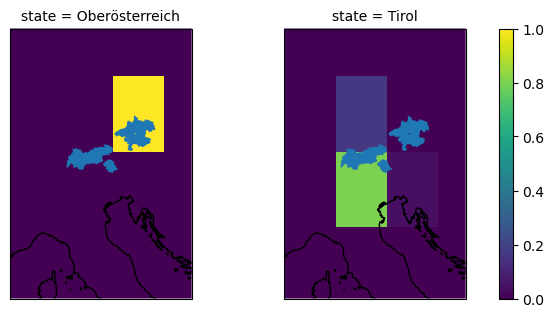

In [20]:
# Convert sparse matrix to numpy array, it has size : (n_in, n_out)
# So reshape to the same shape as ds + polygons
w = xr.DataArray(
    savg.weights.data.todense().reshape(austria.geometry.size, *ds.lon.shape),
    dims=("state", *ds.lon.dims),
    coords=dict(state=out.state, **ds.lon.coords),
)

proj = ccrs.PlateCarree()
a = w.plot(col='state', x='x', y='y', subplot_kws={'projection':proj}, transform=ccrs.PlateCarree())
for ax in a.axes.flat:
    ax.coastlines()
    ax.set_extent([7,17, 42,52])
    austria.plot(ax=ax)

### What we came here for: temperature projection for each state

In [12]:
# lets loop over all datasets (models)
timeseries = {}

for model, model_ds in ddict_merged.items():
    
    if not 'lon_verticies' in model_ds: # in some datasets this info is missing (this might need some more work)
        print(f'Could not process {model}: Missing cell bound info')
    else:
        model_ds_converted = convert_bounds(model_ds)
        # needs to be computed for each model separately
        savg = xe.SpatialAverager(model_ds_converted, austria.geometry, geom_dim_name="state")
        out = savg(model_ds_converted.tas)
        out = out.assign_coords(state=xr.DataArray(list(austria["NAME_1"]), dims=("state",)))

        with ProgressBar():
            out = out.load()
        timeseries[model] = out

Could not process CESM2.gn.historical.Amon.tas: Missing cell bound info
[########################################] | 100% Completed | 8.13 ss
[########################################] | 100% Completed | 15.50 s


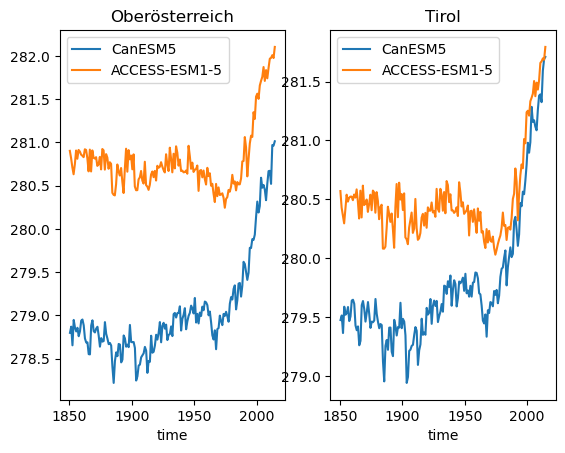

In [27]:

fig, axarr = plt.subplots(ncols=2)
for mi, (model, da) in enumerate(timeseries.items()):
    # annual averages
    da = da.coarsen(time=12).mean()
    for state, ax in zip(da.state, axarr.flat):
        da_state = da.sel(state=state).squeeze()
        # average over ensemble members
        da_state.mean('member_id').plot(ax=ax, color=f"C{mi}", label= model.split('.')[0])
        ax.legend()
        ax.set_title(state.data)